In [2]:
# Load required libraries
# Install the necessary packages if they are not already installed
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("randomForest")) install.packages("randomForest")
if (!require("caret")) install.packages("caret")
if (!require("pROC")) install.packages("pROC")
if (!require("openxlsx")) install.packages("openxlsx")

Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: pROC

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

In [3]:
# Load required libraries
library(tidyverse)
library(randomForest)
library(caret)
library(pROC)
library(openxlsx)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [10]:
# Step 1: Data Preprocessing
# Load the datasets
case_data <- read.csv("PC_case.csv")
control_data <- read.csv("PC_control.csv")
genes_data <- read.csv("geneList.csv")


# Assign column names
colnames(case_data) <- c("chromosome", "start", "end", "variation", "patient_id")
colnames(control_data) <- c("chromosome", "start", "end", "variation", "patient_id")
colnames(genes_data) <- c("gene_id", "placeholder", "chromosome", "gene_start", "gene_end")


# Combine and format data
cnv_data <- bind_rows(case_data %>% mutate(Group = "Case"),
                      control_data %>% mutate(Group = "Control"))

# Feature engineering: Create new features
# Correct the column name from Chromosome to chromosome
cnv_data <- cnv_data %>%
  mutate(chromosome = as.factor(chromosome), # Change 'Chromosome' to 'chromosome'
         Variation_Type = as.factor(variation), # Change 'Type' to 'variation'
         CNV_Length = end - start) # Change 'End' and 'Start' to 'en

# Encode target variable
cnv_data$Target <- ifelse(cnv_data$Group == "Case", 1, 0)

In [12]:
# Step 2: Prepare Data for Machine Learning
# Select features for the model
features <- cnv_data %>%
  select(chromosome, start, end, CNV_Length, Variation_Type, Target)

# One-hot encode categorical features
features <- dummyVars(~., data = features) %>%
  predict(newdata = features) %>%
  as.data.frame()

# Split data into training and testing sets
set.seed(123) # For reproducibility
train_index <- createDataPartition(features$Target, p = 0.7, list = FALSE)
train_data <- features[train_index, ]
test_data <- features[-train_index, ]

In [13]:
# Step 3: Train Random Forest Model
model <- randomForest(Target ~ ., data = train_data, ntree = 100, importance = TRUE)

# Print model summary
print(model)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”



Call:
 randomForest(formula = Target ~ ., data = train_data, ntree = 100,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 9

          Mean of squared residuals: 0.01884557
                    % Var explained: 90.28


In [15]:
# Step 4: Model Evaluation
# Predict on the test data
predictions <- predict(model, test_data, type = "response")

# Convert predictions and test_data$Target to factors with the same levels
# Get the levels present in test_data$Target
all_levels <- levels(as.factor(test_data$Target))

# Ensure both predictions and test_data$Target have the same levels
predictions <- factor(predictions, levels = all_levels)
test_data$Target <- factor(test_data$Target, levels = all_levels)

# Evaluate performance
conf_matrix <- confusionMatrix(predictions, test_data$Target)  # Removed extra as.factor() calls
roc_curve <- roc(test_data$Target, as.numeric(predictions)) # Convert predictions to numeric for roc()

# Print evaluation metrics
cat("Confusion Matrix:\n")
print(conf_matrix)
cat("AUC-ROC:", auc(roc_curve), "\n")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 0 0
         1 1 8
                                          
               Accuracy : 0.8889          
                 95% CI : (0.5175, 0.9972)
    No Information Rate : 0.8889          
    P-Value [Acc > NIR] : 0.7362          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.8889          
             Prevalence : 0.1111          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                        

In [16]:
# Step 5: Identify Important Features
importance <- as.data.frame(importance(model))
colnames(importance) <- c("MeanDecreaseAccuracy", "MeanDecreaseGini")
importance <- importance %>%
  arrange(desc(MeanDecreaseAccuracy))

cat("Top Important Features:\n")
print(importance)

Top Important Features:
                   MeanDecreaseAccuracy MeanDecreaseGini
CNV_Length                   236.488534     4657.6461247
chromosome.19                 25.183382       14.2785431
chromosome.1                  23.397192       14.5568718
chromosome.11                 19.154183       15.9014646
end                           18.580782      204.3663080
start                         18.458102      260.3448371
chromosome.17                 18.266461       16.1835218
chromosome.2                  17.195896       10.8373841
chromosome.6                  14.723701        9.5355431
chromosome.22                 14.122623        6.6844477
chromosome.14                 13.666818        8.3354531
chromosome.10                 13.147503        7.6684115
chromosome.3                  12.503415        9.6818431
chromosome.7                  12.365022       10.0469009
chromosome.4                  12.011591        7.1951674
chromosome.12                 10.576405        6.8124051
Variati

In [19]:
# Step 6: Save Results
# Save important features
write.xlsx(list("Important Features" = importance,
                "Confusion Matrix" = as.data.frame(conf_matrix$table)),
           file = "CNV_Analysis_Results_ML.xlsx")

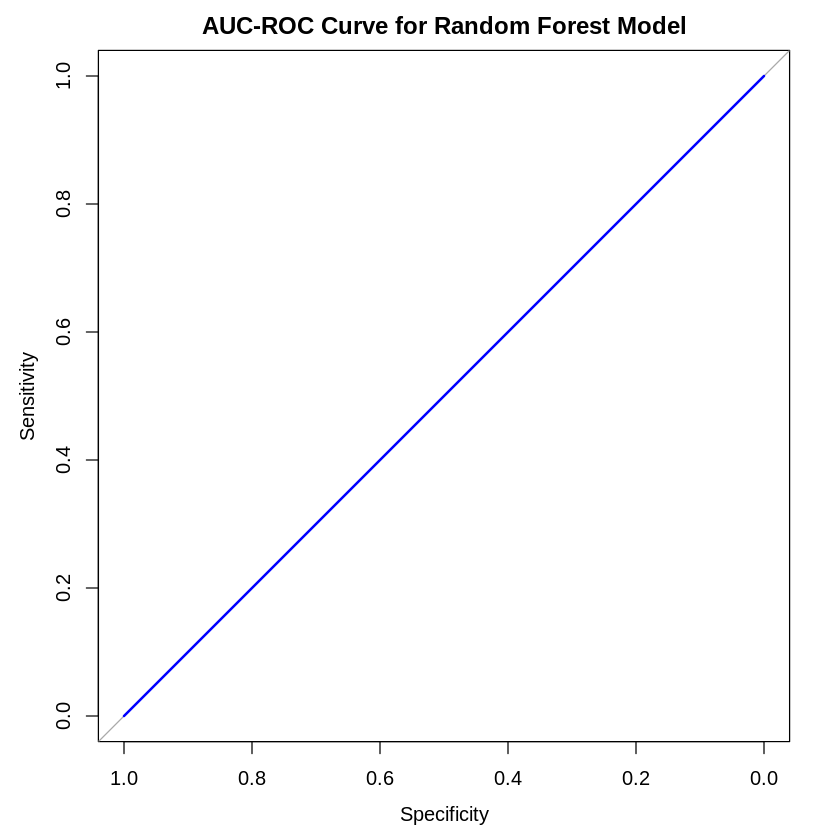

In [20]:
# Step 7: Visualization
# Plot ROC curve
plot(roc_curve, main = "AUC-ROC Curve for Random Forest Model", col = "blue", lwd = 2)

# Save the model for future use
saveRDS(model, file = "random_forest_cnv_model.rds")